***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [6. Deconvolution in Imaging](6_0_introduction.ipynb)  
    * Previous: [6.1 Sky Models](6_1_sky_models.ipynb)  
    * Next: [6.3 CLEAN Implementations](6_3_clean_flavours.ipynb)

***

Import standard modules:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [7]:
from IPython.display import Image
from IPython.core.display import clear_output, display

from scipy.signal import convolve2d

from copy import copy
import time

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import matplotlib.cm as cm

from astropy.io import fits
import aplpy

#Disable astropy/aplpy logging
import logging
logger0 = logging.getLogger('astropy')
logger0.setLevel(logging.CRITICAL)
logger1 = logging.getLogger('aplpy')
logger1.setLevel(logging.CRITICAL)

In [4]:
HTML('../style/code_toggle.html')

***

## 6.2 点源的迭代去卷积（CLEAN）Interative Deconvolution with Point Sources (CLEAN)<a id='deconv:sec:clean'></a>

按照前一节[previous section &#10142;](6_1_sky_models.ipynb)的逻辑，我们可以把点源看作是用于构建天空模型的通用单元，然后引入射电干涉测量领域的标准去卷积方法--CLEAN。去卷积是一个比较广义的术语，学科不同，其具体的技术含义也有所不同，但本质都是把两个卷积（或者近似卷积）到一起的的的函数分离开来，比如本例子中的阵列点扩散函数和天空函数。

If we carry on with the logic from the [previous section &#10142;](6_1_sky_models.ipynb) that we can use point sources as a generic unit for building sky models then we are ready to introduce the standard deconvolution method in radio interfereometry, `CLEAN`. Deconvolution is a broad term, that is defined by different, discipline-specific techniques to separate out two functions which have previously been (approximately) convolved together. Such as in the case of the array point spread function and the sky.

乍看之下，去卷积貌似一个相当简单的问题，我们知道，如何将两个函数$f$ 和 $g$ 卷积到一起，生成一个新函数$h$，其中

This problem of deconvolution seems fairly simple at first glance. We know how to convolve two functions $f$ and $g$ to produce an new function $h$ where

$$h = f \circ g \qquad.$$

给定$h$和另外两个函数之中的一个，比如$g$，根据卷积定理，我们可以去卷积，从而获得$f$。

Given, $h$ and one of the other functions, say $g$ then $f$ can be deconvolved by using the convolution theorem

$$\mathscr{F}\{f\} = \frac{\mathscr{F}\{h\}}{\mathscr{F}\{g\}}$$


看上去我们很容易地就解决了去卷积问题，然而，这只适用于非噪声系统。在[next chapter &#10142;](../7_Observing_Systems/7_0_introduction.ipynb)将会看到，我们的干涉测量观测不可能没有噪声，我们测量得到的可见度函数，是天空跟阵列响应的卷积，再加上一些一起噪声$\epsilon$。

Easy, we have solved deconvolution, unfortunately this is only true for a *noise-less system*. And, as we will see in the [next chapter &#10142;](../7_Observing_Systems/7_0_introduction.ipynb), our interferometric observation definitely contains noise in the visibility measurements. When we are measuring the sky visibility function we are convolving the sky with the array response and some instrumental noise $\epsilon$.

$$I^D = \text{PSF} \circ I_{true} + \epsilon$$

如果$\epsilon$小于天空信号，可以近似为0，采用简单的被称为“逆滤波”的去卷积方法。不幸的是，射电天文中多数时候需要用到去卷积，而且$\epsilon$并不小。逆滤波应用到噪声系统，会产生差的原始信号估计。为什么逆滤波不适用于综合成像，让我们来看一个例子，把逆滤波的方法用到一次简单的KAT-7观测。因为是模拟数据，所以我们有确切的天空模型，并生成了无需校准的脏图。

If this $\epsilon$ is small compared to the sky signal then we can approximate $\epsilon$ as 0 and do this simple deconvolution method, which is called *inverse filtering*. Unfortunately, in radio astronomy, and most cases where deconvolution is required, $\epsilon$ is not small. Applying an inverse filter to a noisy signal will result in a poor estimate of the original signal. As an example of why inverse filtering fails in synthesis imaging let us apply the method to the simple KAT-7 observation we have been using in previous sections. As this is simulated data we know the exact sky model and produce a dirty image which is free of any calibration issues, i.e. the observation is full known.

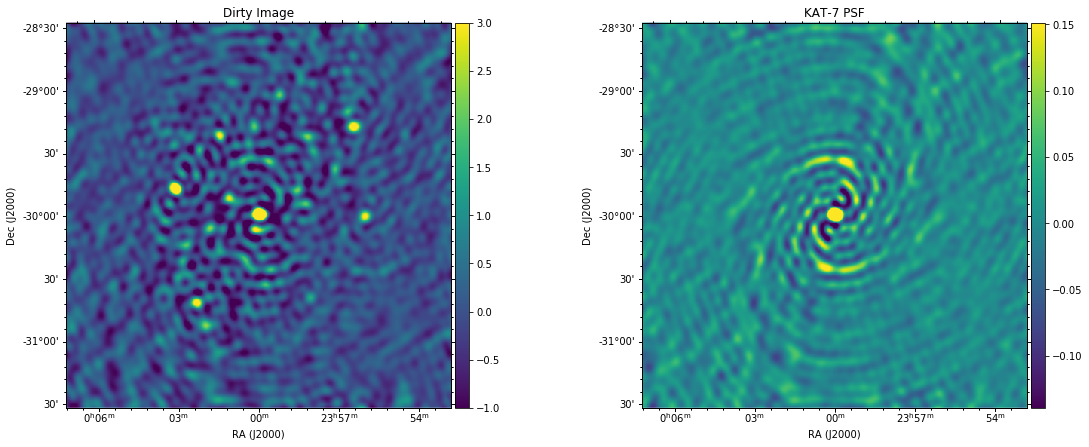

In [9]:
fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-dirty.fits', \
                       figure=fig, subplot=[0.0,0.1,0.35,0.8])
gc1.show_colorscale(vmin=-1., vmax=3.0, cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('Dirty Image')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-psf.fits', \
                       figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(cmap='viridis')
#gc2.hide_axis_labels()
#gc2.hide_tick_labels()
plt.title('KAT-7 PSF')
gc2.add_colorbar()

fig.canvas.draw()

左：KAT-7的点源脏图。右：KAT-7的PSF响应，6小时，高度角$-30^{\circ}$。

*Left: Dirty image of a point source field observed by KAT-7. Right: PSF response of KAT-7 for a 6 hour observation at a declination of $-30^{\circ}$.*

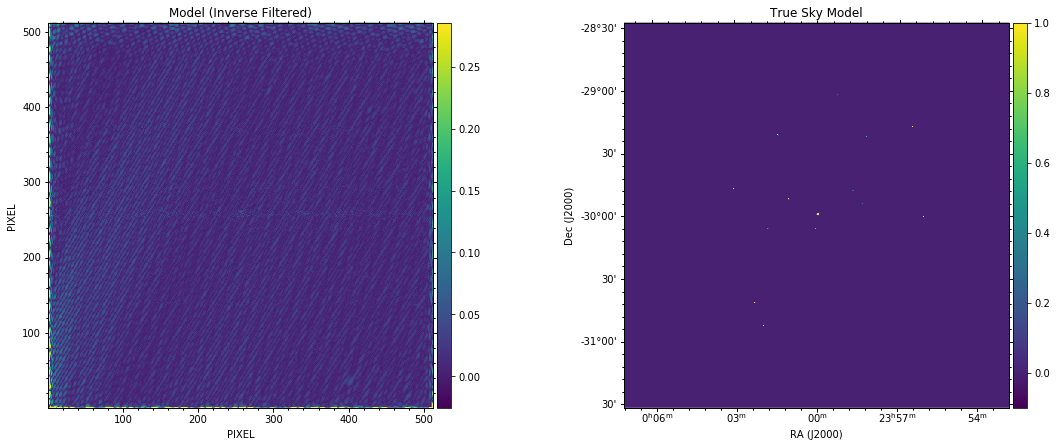

In [11]:
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-psf.fits') #KAT-7 PSF
psf = fh[0].data[0,0]
fh = fits.open('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-dirty.fits') #Dirty image
dirtyImg = fh[0].data[0,0]

#apply inverse filter
sampFunc = np.fft.fft2(psf)
obsVis = np.fft.fft2(dirtyImg)
trueVis = obsVis / sampFunc
trueImg = np.abs(np.fft.ifft2(trueVis))

fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure(trueImg, figure=fig, subplot=[0.0,0.1,0.35,0.8])
gc1.show_colorscale(cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('Model (Inverse Filtered)')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure('../data/fits/deconv/KAT-7_6h60s_dec-30_10MHz_10chans_uniform_n100-model.fits', \
                       figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(vmin=-0.1, vmax=1.0, cmap='viridis')
#gc2.hide_axis_labels()
#gc2.hide_tick_labels()
plt.title('True Sky Model')
gc2.add_colorbar()

fig.canvas.draw()

左：逆滤波的噪声天空模型。右：真实点源天空模型。

*Left: a noise sky model derived by applying an inverse filter. Right: The true point source sky model.*

通过对阵列的PSF和脏图进行逆过滤运算，得到天空模型：

We compute the inverse filtered deconvolved sky model using the array PSF and dirty image:

$$I_{true} = \mathscr{F}^{-1} \left \{ \frac{\mathscr{F}\{I^D\}}{\mathscr{F}\{\textrm{PSF}\}} \right \} $$

上面左图是逆过滤得到的天空模型，都是噪声，只在边缘有些边缘效应导致的亮结构。可以看出，我们没有复原出真实天空模型（右图）中的任何源，需要另外的方法处理噪声。

The resulting sky model in the left figure above is just noise with some bright structure along the edges due to the edge effects. As we can see, we do not recover any sources in the true sky model (right figure above). We need a different method to deal with the noise.

我们可以对上述逆过滤进行调整，只选择部分图像（只有源没有噪声）。我们在脏图上设置一个最小阈值

Perhaps we can modify this inverse filter method by only selecting a part of the image which is clearly made up of sources and not noise. We can do this by setting a minimum threshold on the dirty image and applying the inverse filter to the thresholded image.

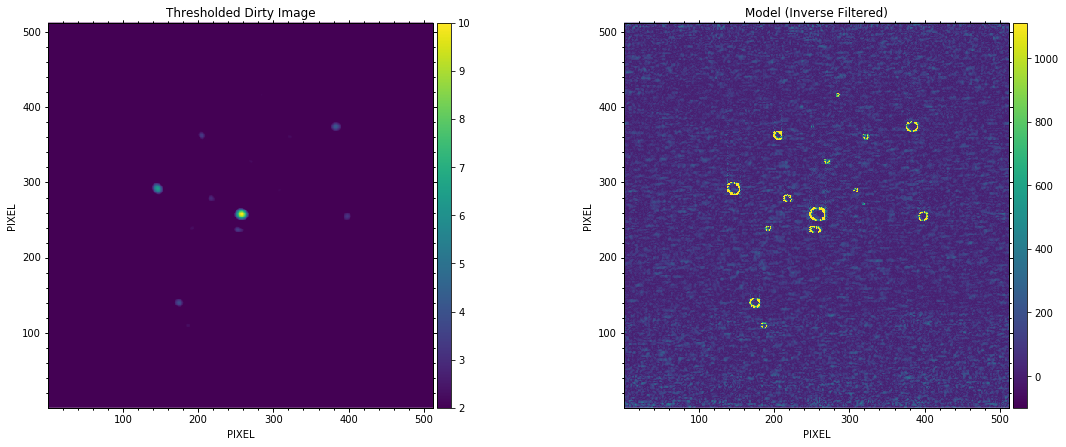

In [12]:
#clip the dirty image to only select pixels above a minimum threshold, set all other pixels to zero
thresh = 2.
clippedDirtyImg = np.clip(dirtyImg, thresh, np.max(dirtyImg))

#apply inverse filter
sampFunc = np.fft.fft2(psf)
obsVis = np.fft.fft2(clippedDirtyImg)
trueVis = obsVis / sampFunc
trueImg = np.abs(np.fft.ifft2(trueVis))

fig = plt.figure(figsize=(16, 7))

gc1 = aplpy.FITSFigure(clippedDirtyImg, figure=fig, subplot=[0.0,0.1,0.35,0.8])
gc1.show_colorscale(vmin=thresh, vmax=10.0, cmap='viridis')
#gc1.hide_axis_labels()
#gc1.hide_tick_labels()
plt.title('Thresholded Dirty Image')
gc1.add_colorbar()

gc2 = aplpy.FITSFigure(trueImg, figure=fig, subplot=[0.5,0.1,0.35,0.8])
gc2.show_colorscale(cmap='viridis')
#gc2.hide_axis_labels()
#gc2.hide_tick_labels()
plt.title('Model (Inverse Filtered)')
gc2.add_colorbar()

fig.canvas.draw()

*Left: Dirty image thresholded to a minimum of 2. Right: The sky model recovered by applying inverse filtering to the thresholded dirty image.*

By applying a threshold to the dirty image (figure above on the left) we are effectively selecting out only signal so then we should be able to recover a sky model of at least the brightest sources. Unfortunately, we do not, as can be seen in the figure above on the right. Instead we see rings around the bright sources. This is because we are removing the PSF structure around the sources in the dirty image. When we apply the inverse PSF filter those missing sidelobes result in source edge effects, i.e. rings. Now, this is not terrible as we could go through the image detecting circles with a Hough transform and come up with a sky model of positions (but not necessarily flux). But, surely we could do something even better.

First, we know the PSF response of the array. Second, we know that every source in the sky is convolved with (approximately) that PSF. We just need to find sources, which are not due to noise, and subtract the PSF multiplied by a factor (to account for different flux values) from that position in the image, and then add that position and flux multiplier to a sky model. Further, since each pixel contains some amount of noise or possible flux due to the PSF from some other source, we do not want to subtract all the flux in a single pixel in one go. Instead, we could iteratively subtract a portion of the flux in a pixel until some noise threshold is reached. This is called *iterative deconvolution*, a type of *greedy algorithm*, which is the basis what we call the class of `CLEAN` deconvoloution algorithms in synthesis imaging.

To understand the details of `CLEAN` lets do a swift review of the visibility sampling function and the array PSF.

## 6.2.1 Sampling, the PSF and the dirty image<a id='deconv:sec:sampling'></a>

In [$\S$ 5.2 &#10142;](../5_Imaging/5_2_sampling_functions_and_psfs.ipynb) we discussed the effects of sampling in imaging. When we observe with a radio interferometric array we collect visibility data on a range of $uv$ coordinates, which we then Fourier transform into an image. The $uv$ coordinates of the visibility data don't fully cover the $uv$-plane. We saw examples of this in plots of KAT-7 $uv$ converage. For example:

In [ ]:
Image(filename='../5_Imaging/figures/uvcoverage/KAT-7_6h60s_dec-30_10MHz_10chans.png')

*Figure: uv coverage from a declination $-30^{\circ}$, 6 hour, 10 MHz observation with KAT-7.*

Conceptually, we can think of this partial $uv$ coverage as the product of the complete visibility function with full $uv$ coverage filling the UV-plane $V(u,v)$, with a sampling function $S(u,v)$ that is unity (for uniform weighting) where we have $uv$ samples and zero where we don't:

$$ S(u,v) \cdot V_{true}(u,v) $$

From the van Cittert-Zernike Theorem we know our image on the sky is the Fourier transform of the conceptual complete visibility function:

$$ I_{true}(l,m) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} V_{true}(u,v) \; e^{-2\pi i(ul+vm)} \; du \, dv$$

But what we get from the interferometer isn't $V_{true}(u,v)$, it is the incomplete $uv$ coverage product $S(u,v) \cdot V_{true}(u,v)$:

$$ \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} S(u,v) \cdot V_{true}(u,v) \; e^{-2\pi i(ul+vm)} \; du \, dv \;=\; ?? $$

How do we deal with this? The Convolution Theorem states that multiplication in one domain is equivalent to convolution in the Fourier domain:

$$ h \cdot g \;\; \rightleftharpoons \;\; H \; \circ \; G $$

In our incomplete $uv$-coverage situation, we are multiplying the conceptual complete visibility function $V_{true}(u,v)$ by a sampling function $S(u,v)$, which equates to a convolution in the image domain:

$$ S(u,v) \cdot V_{true}(u,v) \;\; \rightleftharpoons \;\; \textrm{PSF}(l,m) \; \circ \; I_{true}(l,m) $$

where $I_{true}(l,m)$ is the true sky image, the Fourier Transform of the complete visibility $V(u,v)$, and $\textrm{PSF}(l,m)$ is the Fourier transform of the sampling function $S(u,v)$, the point spread functions. In older literature the term *dirty beam* is often used instead of the PSF, they are equivalent. We term the product $\textrm{PSF}(l,m) \; \circ \; I_{true}(l,m)$ the "Dirty Image" $I^D(l,m)$.

<p class=conclusion>
  <font size=4><b>Summary</b></font>
  <br>
  <br>
&bull;
The Fourier transform of our sampled visibility $V(u,v)$ data gives us a dirty image $I^D(l,m)$.
<br>
&bull; 
The dirty image $I^D(l,m)$ is the convolution of the true image $I_{true}(l,m)$ with the PSF.
<br>
&bull;
The PSF (or dirty beam $\textrm{PSF}(l,m)$) is the Fourier transform of the sampling function $S(u,v)$
</p>

## 6.2.2 Point Source Assumption<a id='deconv:sec:point_source'></a>

One convenient feature of radio astronomy images is that they consist *for the most part* of point sources on an empty sky. This is just an approximation of course, but it is an approximation that makes decomvolution much easier, because we can then consider our PSF as a point source response (or impulse response) - every point source on the true image is replaced by a PSF in the dirty image. 

Let's set up a little example of this.

First, set up a toy sky, with three point sources and some noise:

In [ ]:
imsize = 50

# create noise background
noise_rms = 0.1
I = noise_rms*(np.random.random([imsize,imsize])-0.5)

# add three point sources with different flux values
I[20,20] += 1
I[32,15] += 1.45
I[30,34] += 1.12

plt.imshow(I, cmap=cm.jet, interpolation='nearest')
plt.colorbar()
plt.title('$I_{true}(l,m)$');

Now set up a fake PSF. We will just make up a star shape to be the PSF:

In [ ]:
PSFsize = 13
PSF = np.zeros([PSFsize,PSFsize])
PSFmid = (PSFsize - 1)/2
PSF[:,PSFmid] = 0.5
PSF[PSFmid,:] = 0.5
d1, d2 = np.diag_indices_from(PSF)
PSF[d1,d2] = 0.5
PSF[d1,d2[::-1]] = 0.5
PSF[PSFmid-2:PSFmid+3,PSFmid-2:PSFmid+3] = 0
PSF[PSFmid-1:PSFmid+2,PSFmid-1:PSFmid+2] = 0.75
PSF[PSFmid,PSFmid] = 1.0

plt.imshow(PSF, cmap = cm.jet, interpolation='nearest')
plt.colorbar()
plt.title('PSF(l,m)');

Now we convolve our true sky image $I_{true}(l,m)$ with the PSF, to get the dirty image $I^D(l,m)$

In [ ]:
I_dirty = convolve2d(I,PSF,mode='same')

Lets plot all three together to see what we have just done:

In [ ]:
fig, axes = plt.subplots(figsize=(16,16))

plt.subplot(131)
plt.imshow(I, cmap=cm.jet, interpolation='nearest')
plt.title('$I_{true}(l,m)$')

plt.subplot(132)
plt.imshow(PSF, cmap=cm.jet, interpolation='nearest')
plt.xlim(-15,25)
plt.ylim(-15,25)
plt.title('PSF(l,m)')

plt.subplot(133)
plt.imshow(I_dirty, cmap=cm.jet, interpolation='nearest')
plt.title('Dirty image $I^D(l,m)$');

## 6.2.3 CLEAN <a id='deconv:sec:clean'></a>

Now we are ready to develop a simple version of the iterative deconvolution `CLEAN` algorithm called [<cite data-cite='1974A&AS...15..417H'>Högbom's method</cite> &#10548;](http://adsabs.harvard.edu/abs/1974A%26AS...15..417H). We will describe Högbom's simple `CLEAN` method here and discuss advances in `CLEAN` algorithms in the [next section &#10142;](6_3_clean_flavours.ipynb).

In Högbom's `CLEAN`, the deconvolution is performed by iteratively finding peaks in the image and removing scaled versions of the PSF at the peak pixel positions. It is an *image-domain* `CLEAN`, meaning that the deconvolution is done entirely in the image $lm$-plane (covered in the next section is the development of *visibility-domain* version of `CLEAN`). Högbom's method is further discussed in the [next section &#10142;](6_3_clean_flavours.ipynb). The version of Högbom's method below is intended to be a simlpe example, for a generic implementation of the method see the [Högbom's Method notebook &#10142;](hogbom_clean.ipynb).

*** Högbom's Algorithm (Image-domain CLEAN): ***

1. Make a copy the dirty image $I^D(l,m)$ called the residual image $I^R(l,m)$.
2. Find the maximum pixel value and position of the maximum in the residual image $I^R(l,m)$.
3. Subtract the PSF multiplied by the peak pixel value $f_{max}$ and a gain factor $g$ from the residual image $I^R(l,m)$ at the position of the peak.
4. Record the position and magnitude of the point source subtracted in a model, i.e. $g \cdot f_{max}$.
5. Go to (Step 2.), unless all remaining pixel values are below some user-specified threshold or the number of iterations have reached some user-specified limit.
6. Convolve the accumulated point source sky model with a restoring beam, termed the CLEAN beam (usually a Gaussian fitted to the main lobe of the dirty beam)
7. Add the remainder of the residual image $I^R(l,m)$ to the CLEAN image formed in (6.) to form the final restored image.


* **Input:** Dirty image, PSF
* **Parameters:** gain, iteration limit *OR* flux threshold
* **Output:** Sky model, residual image, restored image

Let us use the algorithm steps above to deconvolve the sky model from the dirty image:

In [ ]:
# ------------------------------------------------
# Step 1: copy the dirty image to a residual image
# ------------------------------------------------
I_residual = copy(I_dirty)

# set up the input parameters 
#   (you can change these later to see how they impact the algorithm)
gain = 0.2
niter = 100
threshold = 5.*noise_rms

plotmax = np.max(I)
plotmin = np.min(I)
model = []

# plot dirty image to compare to the residual image as we run the algorithm
f, ax = plt.subplots(1,2,figsize=[16,6])
ax[0].set_title('$I^D(l,m)$')
ax[0].imshow(I_dirty, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest');

for i in range(niter):  
    print 'Iteration {0}:'.format(i,)
    
    # ------------------------------------------------
    # Step 2. Find the strength and position of the peak in the residual image
    # ------------------------------------------------
    f_max = np.max(I_residual)
    p_max = np.where(I_residual==f_max)
    
    # ------------------------------------------------
    # Step 3. Subtract gain*f_max*PSF centred on $p_{max}$ from the residual image
    # ------------------------------------------------    
    p_x, p_y = p_max
    I_residual[p_x-PSFmid:p_x+PSFmid+1,p_y-PSFmid:p_y+PSFmid+1] -= gain*f_max*PSF
    print 'Peak: {0}    Position: {1},{2}'.format(f_max,p_x[0],p_y[0])
    
    # ------------------------------------------------
    # Step 4. Record the peak position and the magnitude subtracted in the model
    # ------------------------------------------------        
    model.append([p_x[0], p_y[0], gain*f_max])
    
    # ------------------------------------------------
    # Step 5. Repeat from (2.), unless residual image < threshold
    # ------------------------------------------------      
    if np.max(I_residual) < threshold: 
        print 'Residual map peak is less than threshold {0}'.format(threshold,)
        break

        
    # plot the new residial next to the original image 
    ax[1].imshow(I_residual, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest')
    ax[1].set_title('I_residual(l,m)')    
    # show the plot, then get ready for the next plot
    plt.draw()
    clear_output(wait=True)
    time.sleep(0.2)
    display(f)
    ax[1].cla()
    plt.close()  

Let us plot the original dirty image and the final residual image scaled to see the residuals:

In [ ]:
plotmax = np.max(I_residual)
plotmin = np.min(I_residual)

fig, axes = plt.subplots(figsize=(16,6))

plt.subplot(121)
plt.title('$I^D(l,m)$')
plt.imshow(I_dirty, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.title('$I^R(l,m)$')
plt.colorbar()
plt.imshow(I_residual, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest');

After a few iterations the residual image is beginning to look noise like, with some PSF structure remaining. As the remaining pixel value approach the noise level we need to halt deconvolution. This is a tricky decision and many issues occur when we 'over' or 'under' deconvolve an image. The resulting artefacts are further exasperated by poor calibration, but that will come later. For now though, the process of halting an iterative deconvolution requires setting either a mimimum flux threshold which halts when all pixels in the residual image are at or below the threshold, or we keep track of the number of iterations and halt after a specified number of cycles.

As for the final sky model, we can print the components.

In [ ]:
# now sum the accumulated point source model ("clean components") into a model image
print 'Clean components:'
print 'x  y  flux'

I_model = np.zeros([imsize,imsize])
for x, y, f in model:
    print x, y, f
    I_model[x,y] += f

As we can see, many of the components are at or near the same pixel values. We should expect this as we are not removing all the flux from a pixel during an iteration, only a portion of the flux which is determined by the gain $g$ scale factor. These are not separate sources, but in the sky model they are presented as such. An additional step of source finding ([$\S$ 6.5 &#10142;](6_5_source_finding.ipynb)) needs to be applied to the model in order to combine these sources.

Plotting the deconvolved sky model image next to the original true sky model image (below) we can see that the three sources are in the new sky model, though the recovery is not perfect. Perhaps we did under-deconvolved, perhaps we are including some noise into the sky model, there are a number of issues that cause deconvolution to be imperfect. But, what we can see is that iterative deconvolution produces more realistic results compared to the inverse filtering methods we started the section discussing.

In [ ]:
plotmax = np.max(I)
plotmin = np.min(I)
fig, axes = plt.subplots(figsize=(16,6))

plt.subplot(121)
plt.title('True Sky')
plt.imshow(I, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.title('Deconvolved Sky')
plt.imshow(I_model, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest')
plt.colorbar();

The last steps of `CLEAN` are somewhat optional, they are performed to produce a 'restored' image, this can be thought of an idealized image produced by an interferometric array with the same resolution as the observing array but with all spatial modes (up to the maximum resolution) fully sampled. That is, a restoring beam, which is usually taken to be a 2-D Gaussian of the same width as the main lobe of the PSF, is convoled with the point source sky model. This is done to reintroduce the the resolution limits of the array without including the PSF sidelobe structure. The restored image is the 'pretty' image we like to show off.

In our toy example here it is hardly worth doing a proper Gaussian fit, but let's do it anyway:

In [ ]:
# first get just the main lobe of the star shaped PSF
main_lobe = np.zeros([PSFsize,PSFsize])
main_lobe[PSFmid-1:PSFmid+2,PSFmid-1:PSFmid+2] = 0.75
main_lobe[PSFmid,PSFmid] = 1.0

fig, axes = plt.subplots(figsize=(16,6))
plt.subplot(121)
plt.imshow(PSF, cmap=cm.jet, interpolation='nearest')
plt.colorbar()
plt.title('PSF(l,m)');

plt.subplot(122)
plt.imshow(main_lobe, cmap=cm.jet, interpolation='nearest')
plt.colorbar()
plt.title('main lobe(l,m)');

In [ ]:
# now fit a symmetric 2D gaussian to the main lobe
import scipy.optimize as opt

def gaussian2dsymmetric((x,y),A,x0,y0,sigma):
    gauss2d = A*np.exp(-((x-x0)**2.0 + (y-y0)**2.0)/(2.*sigma**2.0))
    return gauss2d.ravel()

x,y = np.meshgrid(range(PSFsize),range(PSFsize))
popt, pcov = opt.curve_fit(gaussian2dsymmetric,(x, y),main_lobe.ravel(), p0=[1.0,6.5,6.5,2.])
A, x0, y0, sigma = popt
print "Fit results:"
print "A: {0},  x0: {1}  y0: {2}  sigma: {3}".format(A,x0,y0,sigma)

# use fitted values to create CLEAN beam (or restoring beam)
#   normalise by dividing through by A
clean_beam = gaussian2dsymmetric((x,y),A,x0,y0,sigma).reshape(PSFsize,PSFsize)/A

In [ ]:
# plot the CLEAN beam
plt.imshow(clean_beam, cmap=cm.jet, interpolation='nearest')
plt.colorbar()
plt.title('CLEAN beam(l,m)');

And now we can convolve the sky model with the restoring beam and add back in the residuals to produce the final restored image:

In [ ]:
# ------------------------------------------------
# Step 6: convolve the model with the CLEAN beam
# ------------------------------------------------
I_restored = convolve2d(I_model,clean_beam,mode='same') 

# ------------------------------------------------
# Step 7: add the residuals back to the restored image
# ------------------------------------------------
I_restored = I_restored + I_residual

Now let us plot the results of the CLEAN:

In [ ]:
plotmax = np.max(I_dirty)
plotmin = np.min(I_dirty)

fig, axes = plt.subplots(figsize=(16,12))

plt.subplot(221)
plt.imshow(I, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest')
plt.title('$I_{true}(l,m)$')
plt.colorbar()

plt.subplot(222)
plt.colorbar()
plt.title('$I^D(l,m)$')
plt.imshow(I_dirty, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest');

plt.subplot(223)
plt.title('I_model(l,m)')
plt.imshow(I_model, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest')
plt.colorbar()

plt.subplot(224)
plt.colorbar()
plt.title('I_restored(l,m)');
plt.imshow(I_restored, cmap=cm.jet, vmax=plotmax, vmin=plotmin, interpolation='nearest');

Notice how the `CLEAN` is imperfect!

Even in a simple field of distant point sources, with no noise, PSF side-lobes can overlap and add up which leads to wrongly identifying sources with `CLEAN`. And as soon as we add noise the situation degrades further - when we start CLEANing close to the noise level then noise starts being added to the model as sources. Also individual point sources can be subtracted in multiple components in adjacent pixels.

But having said that - `CLEAN` usually performs adequately. As long as we are careful to look at the results of our `CLEAN`, and are aware of image artifacts and noise levels!

There are also lots of parameters to fiddle with, even in our simple `CLEAN`. Try changing the gain and cutoff threshold and re-run this notebook, to see how they effect the `CLEAN`. Also try changing the noise level of the original map by changing `noise_rms` - you will see how the `CLEAN` performs better when the signal-to-noise ratio is higher.

In the next section we will dive deeper into the different implementations of `CLEAN`, limitations of point source-based deconovlution, and current developments in advancing deconvolution methods.

***

Next: [6.3 CLEAN Implementations](6_3_clean_flavours.ipynb)

<div class=warn><b>Future Additions:</b></div>
